# Импорты и предварительные настроечки

In [1]:
%%capture
!pip install kats
!sudo pip install xlsxwriter

In [2]:
import logging
import warnings

logging.disable(level=logging.CRITICAL)
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

In [48]:
sns.set()

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! ls -l '/content/drive/MyDrive/Алгоритмы на страже экономической стабильности/DATA/'

total 48
-rw------- 1 root root 19520 Aug 28 05:24 0.xlsx
drwx------ 2 root root  4096 Aug 28 05:45 100_f_SOLUTION
drwx------ 2 root root  4096 Aug 28 04:38 100_f_TIME_TEST
drwx------ 2 root root  4096 Aug 27 20:37 SOLUTIONS
drwx------ 2 root root  4096 Aug 27 20:32 TESTS_NEW
drwx------ 2 root root  4096 Aug 27 20:32 TESTS_OLD
drwx------ 2 root root  4096 Aug 27 20:33 TRAIN
drwx------ 2 root root  4096 Aug 27 20:34 TRAINED_META


In [11]:
# папка со всеми данными
# может отличаться от пути при запуске

PATH = '/content/drive/MyDrive/Алгоритмы на страже экономической стабильности/DATA/'

In [8]:
import pandas as pd
from pandas import tseries
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from numpy import nan, inf
from kats.models.metalearner.metalearner_modelselect import MetaLearnModelSelect
from kats.models.metalearner.get_metadata import GetMetaData
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.theta import ThetaModel, ThetaParams
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.arima import ARIMAModel, ARIMAParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from seaborn.regression import algo
from pandas import ExcelWriter

# Загружаем Train.xlsx и делаем небольшую предобработку

In [9]:
def alter_train(df_train):
    df = df_train.copy()
    df = df.drop(index=0)
    time_col = df.pop('Unnamed: 0')
    df = df.set_index(pd.to_datetime(time_col, format='%Ym%m'))
    return df

In [12]:
train_monthly = alter_train(pd.read_excel(PATH + 'TRAIN/Train.xlsx', sheet_name = 'Monthly'))
train_quarterly = alter_train(pd.read_excel(PATH + 'TRAIN/Train.xlsx', sheet_name = 'Quarterly')) 

# Создаем мета-датафреймы

Мы используем концепцию MetaLearning. Настраивая модель-классификатор на тренировочных данных и прогоняя на них основные алгоритмы для работы с временными рядами (ARIMA, SARIMA, Facebook Prophet, STFL, Theta, Holt-Winters), мы учимся подбирать наиболее оптимальный алгоритм для временного ряда, который модель еще не видела

Тренировочный мета-датафрейм по месячным данным состоит из 69 строк (по одной на каждый временной ряд), для каждой строки влючена информация об извлеченных из ряда мета-признаков, оптимальных параметрах каждый обученной модели и, как было сказано ранее, указан оптимальный тип алгоритма

Создание датафреймов занимает несколько часов, поэтому в этом ноутбуке мы загружаем составленные заранее


In [13]:
def make_meta_df(train_data):
    features = train_data.columns
    num_of_features = len(features)
    time_col = train_data.index
    meta_train = pd.DataFrame(columns=['hpt_res', 'features',	'best_model', 'search_method', 'error_method'])
    errors = []
    for ind, feature in enumerate(features):
        print(f'Working on {ind + 1}/{num_of_features}')
        try:
            df = pd.DataFrame({'time': time_col, 'value': train_data[feature].astype(float)}).dropna()
            meta_ts = TimeSeriesData(df)
            MD = GetMetaData(data=meta_ts, error_method='mse')
            meta_dict = MD.get_meta_data()

            meta_dict['hpt_res'] = [meta_dict['hpt_res']]
            meta_dict['features'] = [meta_dict['features']]
            meta_df = pd.DataFrame.from_dict(meta_dict)

            meta_train = meta_train.append(meta_df)
        except:
            errors.append(feature)
    return meta_train, errors

In [14]:
# meta_train_monthly, errors_m = make_meta_df(train_monthly)
# meta_train_quarterly, errors_q = make_meta_df(train_quarterly)
# meta_train_monthly.to_excel('TRAINED_META/monthly.xlsx')  
# meta_train_quarterly.to_excel('TRAINED_META/quarterly.xlsx')

meta_train_monthly = pd.read_excel(PATH + 'TRAINED_META/monthly.xlsx')
meta_train_quarterly = pd.read_excel(PATH + 'TRAINED_META/quarterly.xlsx')

Ошибок у нас не было, поэтому обрабатывать их отдельно не пришлось. Сохраняем данные, на которых в дальнейшем будут обучаться предикторы.

# Тюнинг мета-моделей

Внутри библиотеки Kats уже созданы необходимые инструменты для корректной работы алгоритмов на новых данных

In [15]:
def improve_trained_meta(trained_meta):
    trained_meta_new = trained_meta.drop(columns='Unnamed: 0')
    trained_meta_new['hpt_res'] = trained_meta_new['hpt_res'].apply(lambda x: eval(x))
    trained_meta_new['features'] = trained_meta_new['features'].apply(lambda x: eval(x))
    return trained_meta_new

def get_predictor(trained_meta, verbose=True):
    metadata_list = trained_meta.to_dict(orient='records')
    predictor = MetaLearnModelSelect(metadata_list)
    predictor.preprocess(downsample=False, scale=True)
    results = predictor.train()
    if verbose:
        print(pd.DataFrame(results))
    return predictor, results['clf_accuracy']

In [21]:
trained_meta_monthly = improve_trained_meta(meta_train_monthly)
trained_meta_quarterly = improve_trained_meta(meta_train_quarterly)

Пример того, как выглядит мета-датафрейм:

In [22]:
trained_meta_monthly.head()

,hpt_res,features,best_model,search_method,error_method
0,"{'arima': ({'p': 4, 'd': 1, 'q': 4}, 0.0093493...","{'length': 156, 'mean': 0.6109671247919318, 'v...",theta,RandomSearch,mse
1,"{'arima': ({'p': 2, 'd': 1, 'q': 4}, 0.0004075...","{'length': 156, 'mean': 0.521019402281658, 'va...",sarima,RandomSearch,mse
2,"{'arima': ({'p': 3, 'd': 1, 'q': 2}, 0.0011177...","{'length': 156, 'mean': 0.5072024985358922, 'v...",arima,RandomSearch,mse
3,"{'arima': ({'p': 3, 'd': 1, 'q': 1}, 0.0011906...","{'length': 156, 'mean': 0.48622517838261925, '...",holtwinters,RandomSearch,mse
4,"{'arima': ({'p': 4, 'd': 1, 'q': 2}, 0.0005435...","{'length': 156, 'mean': 0.5871090656778023, 'v...",sarima,RandomSearch,mse


Под "капотом" процесс обучения мета-моделей стохастичен, поэтому зафиксируем random.state и запустим поиск оптимальной модели

In [26]:
np.random.seed(18)
best_clf, best_acc = None, 0
for _ in range(15):
    monthly_predictor, accuracy = get_predictor(trained_meta_monthly, verbose=False)
    if accuracy > best_acc:
        best_clf, best_acc = monthly_predictor, accuracy
monthly_predictor = best_clf
print("Best accuracy:", best_acc)

Best accuracy: 0.42857142857142855


In [27]:
np.random.seed(18)
best_clf, best_acc = None, 0
for _ in range(15):
    quarterly_predictor, accuracy = get_predictor(trained_meta_quarterly, verbose=False)
    if accuracy > best_acc:
        best_clf, best_acc = quarterly_predictor, accuracy
quarterly_predictor = best_clf
print("Best accuracy:", best_acc)

Best accuracy: 0.75


# Класс для предсказания

Класс будет принимать в конструктор тип модели и оптимальные параметры, подобранные нами под каждый конкретный ряд

Методы класса -- функции для предсказания временного ряда определенной моделью

In [29]:
class Predictors:
    def __init__(self, type_of_predictor, best_params, steps, ts, seasonality=12):
        self.type_of_predictor = type_of_predictor
        self.best_params = best_params
        self.steps = steps
        self.ts = ts
        self.seasonality = seasonality

    def predict(self):
        if self.type_of_predictor == 'prophet':
            return self._Prophet()
        elif self.type_of_predictor == 'sarima':
            return self._SARIMA()
        elif self.type_of_predictor == 'arima':
            return self._Classic_arima()
        elif self.type_of_predictor == 'stlf':
            return self._STLF()
        elif self.type_of_predictor == 'theta':
            return self._Theta()
        elif self.type_of_predictor == 'holtwinters':
            # return self._Holt_Winters() # на практике данный алгоритм показывал очень плохие результаты
            return self._STLF()

    def _Prophet(self):
      params = ProphetParams(seasonality_mode=self.best_params['seasonality_mode'],
                             weekly_seasonality=self.best_params['weekly_seasonality'],
                             daily_seasonality=self.best_params['daily_seasonality']) 
      m = ProphetModel(self.ts, params)
      m.fit()
      fcst = m.predict(steps=self.steps, freq="MS")
      return fcst

    def _Theta(self):
      params = ThetaParams(m=self.best_params['m'])
      m = ThetaModel(data=self.ts, params=params)
      m.fit()
      fcst = m.predict(steps=self.steps, alpha=0.2)
      return fcst

    def _Classic_arima(self):
      params = ARIMAParams(p=self.best_params['p'], d=self.best_params['d'], q=self.best_params['q'])
      m = ARIMAModel(self.ts, params)
      m.fit()
      fcst = m.predict(
          steps=self.steps, 
          freq="MS"
          )
      return fcst

    def _SARIMA(self):
      params = SARIMAParams(
        p=self.best_params['p'], 
        d=self.best_params['d'], 
        q=self.best_params['q'], 
        trend = self.best_params['trend'], 
        seasonal_order=(1, 0, 1, self.seasonality)
        )
      m = SARIMAModel(data=self.ts, params=params)
      m.fit()
      fcst = m.predict(
          steps=self.steps, 
          freq="MS"
          )
      return fcst

    def _Holt_Winters(self):
      params = HoltWintersParams(
          trend=self.best_params['trend'],
          seasonal=self.best_params['seasonal'],
          seasonal_periods=self.best_params['seasonal_periods']
      )
      m = HoltWintersModel(
          data=self.ts, 
          params=params)
      m.fit()
      fcst = m.predict(steps=self.steps, alpha=0.001, beta=0.05, gamma=0.1)
      return fcst

    def _STLF(self):
      ts = self.ts.to_dataframe()
      data = ts.set_index('time')
      stlf = STLForecast(data, ARIMA)
      res = stlf.fit()
      pred = pd.DataFrame()
      pred['fcst'] = res.forecast(self.steps)
      return pred

In [30]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Основной Pipeline

Данная ячейка самая объемная и важная. В ней мы подгружаем тестовые данные по выбранному пути, выбираем нужную модель с оптимальным набором параметров и, наконец, делаем предсказание и сохраняем новые .xlsx файлы в нужную директорию

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




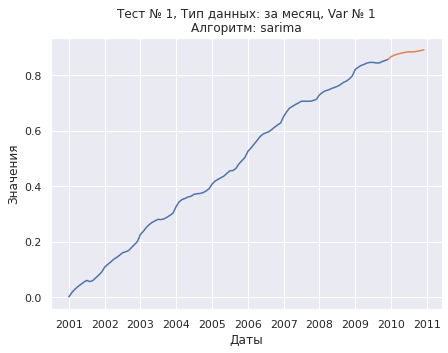

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




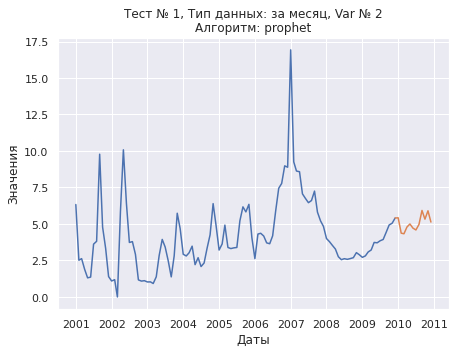

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



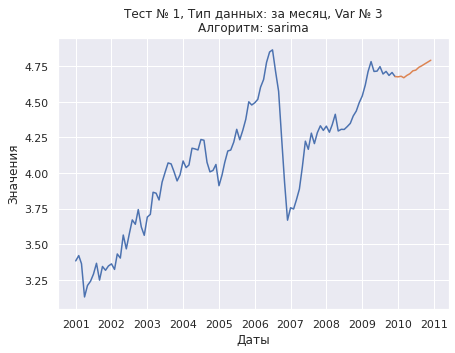

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




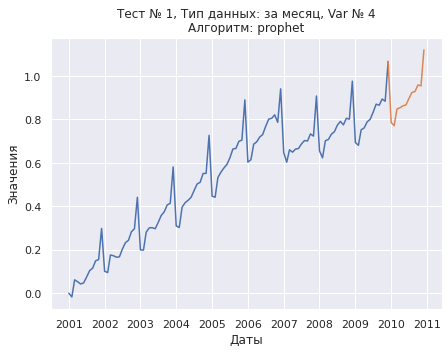

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




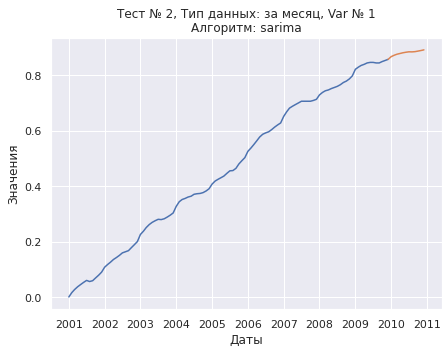

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




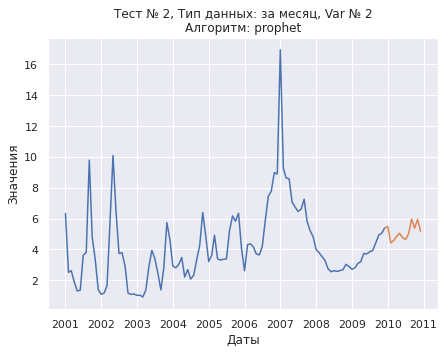

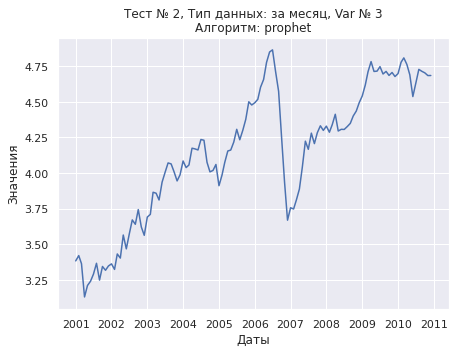

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




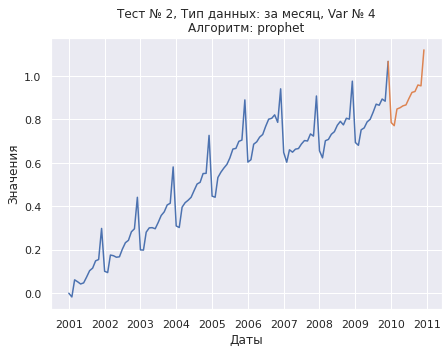

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




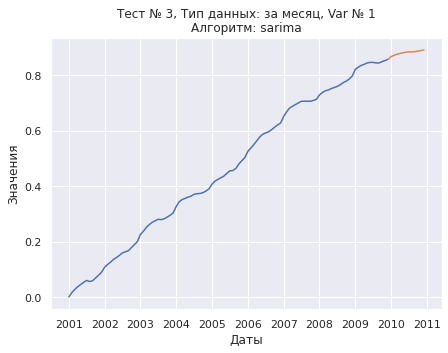

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




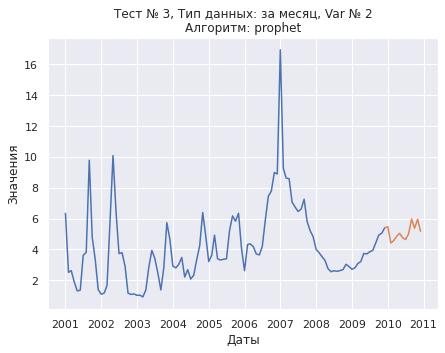

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



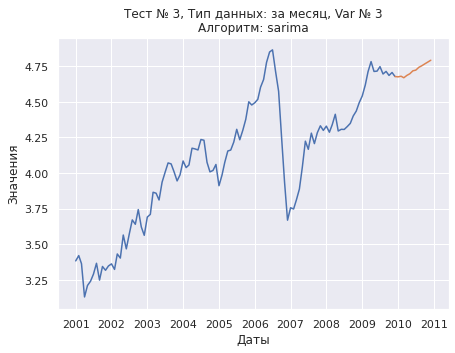

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




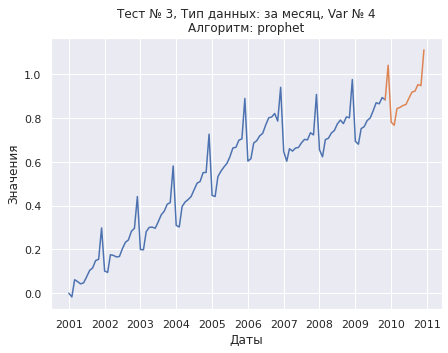

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




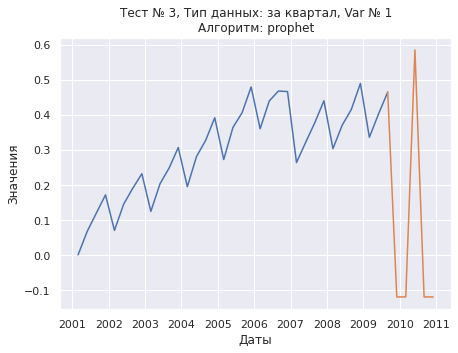

In [50]:
show_plots = True
start, end = 1, 3

for number_of_test_file in tqdm(range(start, end+1)):
    writer = pd.ExcelWriter(PATH + f'SOLUTIONS/prediction{number_of_test_file}.xlsx', engine='xlsxwriter')
    try:
        monthly = pd.read_excel(PATH + f'TESTS_OLD/Test_example{number_of_test_file}.xlsx', sheet_name='Monthly').fillna(0)  # настройка под имеющиеся тестовые данные. TESTS_OLD надо будет поменять на TESTS_NEW
        monthly = monthly.set_index(pd.to_datetime(monthly['Unnamed: 0'].rename('time').apply(lambda data: '20' + data), format='%Ym%m'))
        monthly = monthly.drop(columns='Unnamed: 0') 
        time_column = monthly.index

        new_monthly_df = pd.DataFrame()

        for number_of_var in range(1, monthly.shape[1] + 1):
            curr_var_col = monthly[f'Var{number_of_var}'][monthly[f'Var{number_of_var}'] != 'Forecast']
            number_to_forecast = len(monthly[f'Var{number_of_var}'][monthly[f'Var{number_of_var}'] == 'Forecast'])

            if number_to_forecast != 0:
                ts = TimeSeriesData(time = time_column[:-number_to_forecast], value = curr_var_col.astype('float'))
                best_algorithm = monthly_predictor.pred(ts)
                
                params_data = monthly_predictor.hpt.to_list()
                probable_params = [params_data[i][best_algorithm] for i in range(len(params_data))]

                # найти номер строки в дф с меньшим расстоянием -- взять параметры чисто по индексу в списке!!!!!
                train_series_features = monthly_predictor.metadataX[monthly_predictor.metadataY == best_algorithm].T
                series_features = pd.Series(monthly_predictor.metadata[0]['features'].values()).fillna(0)

                best_index = np.array(list(map(lambda column: cosine_similarity(column.to_numpy().reshape(1, -1), series_features.to_numpy().reshape(1, -1))[0][0], 
                                      [train_series_features[feature] for feature in list(train_series_features)]))).argmax()
                best_params = probable_params[best_index][0]

                predictor = Predictors(best_algorithm, best_params, number_to_forecast, ts, 12)
                predicted = predictor.predict()
                new_col = curr_var_col.append(predicted['fcst'], ignore_index=True)
                threshold = 0.4 * curr_var_col.mean()  # магическое число, но вроде работает
                new_col = new_col.clip(min(curr_var_col) - threshold, max(curr_var_col) + threshold)

            else:
                new_col = curr_var_col.values

            new_monthly_df[f'Var{number_of_var}'] = new_col

            if show_plots and number_to_forecast != 0:
                fig = plt.figure(figsize=(7, 5))
                ax = sns.lineplot(x=time_column[:-number_to_forecast], y=new_col[:-number_to_forecast])
                ax = sns.lineplot(x=time_column[-number_to_forecast-1:], y=new_col[-number_to_forecast-1:])
                ax.set(xlabel='Даты', ylabel='Значения', title=f"Тест № {number_of_test_file}, Тип данных: за месяц, Var № {number_of_var}\nАлгоритм: {best_algorithm}")
                plt.show()
            elif show_plots:
                fig = plt.figure(figsize=(7, 5))
                ax = sns.lineplot(x=time_column, y=new_col)
                ax.set(xlabel='Даты', ylabel='Значения', title=f"Тест № {number_of_test_file}, Тип данных: за месяц, Var № {number_of_var}\nАлгоритм: {best_algorithm}")
                plt.show()

        new_monthly_df = new_monthly_df.set_index(time_column.rename('').map(lambda data: str(data)[2:4] + 'm' + str(data)[5:7]))
        new_monthly_df.to_excel(writer, sheet_name='Monthly')
            
    except ValueError:
        monthly = None

    try:
        quarterly = pd.read_excel(PATH + f'TESTS_OLD/Test_example{number_of_test_file}.xlsx', sheet_name='Quarterly').fillna(0)
        quarterly = quarterly.set_index(pd.to_datetime(quarterly['Unnamed: 0'].rename('time').apply(lambda data: '20' + data), format='%Ym%m'))
        quarterly = quarterly.drop(columns='Unnamed: 0') 
        time_column = quarterly.index

        new_quarterly_df = pd.DataFrame()
        for number_of_var in range(1, quarterly.shape[1]+1):
            curr_var_col = quarterly[f'Var{number_of_var}'][quarterly[f'Var{number_of_var}'] != 'Forecast']
            number_to_forecast = len(quarterly[f'Var{number_of_var}'][quarterly[f'Var{number_of_var}'] == 'Forecast'])

            if number_to_forecast != 0:
                ts = TimeSeriesData(time = time_column[:-number_to_forecast], value = curr_var_col.astype('float'))
                best_algorithm = quarterly_predictor.pred(ts)

                params_data = quarterly_predictor.hpt.to_list()
                probable_params = [params_data[i][best_algorithm] for i in range(len(params_data))]
                
                # найти номер строки в дф с меньшим расстоянием -- взять параметры чисто по индексу в списке!!!!!
                train_series_features = quarterly_predictor.metadataX[monthly_predictor.metadataY == best_algorithm].T
                series_features = pd.Series(quarterly_predictor.metadata[0]['features'].values()).fillna(0)

                best_index = np.array(list(map(lambda column: cosine_similarity(column.to_numpy().reshape(1, -1), series_features.to_numpy().reshape(1, -1))[0][0], 
                                      [train_series_features[feature] for feature in list(train_series_features)]))).argmax()
                best_params = probable_params[best_index][0]

                predictor = Predictors(best_algorithm, best_params, number_to_forecast, ts, 4)
                predicted = predictor.predict()

                new_col = curr_var_col.append(predicted['fcst'], ignore_index=True)
                threshold = 0.4*curr_var_col.mean()
                new_col = new_col.clip(min(curr_var_col) - threshold, max(curr_var_col) + threshold)
              
            else:
                new_col = curr_var_col.values
            
            new_quarterly_df[f'Var{number_of_var}'] = new_col

            if show_plots and number_to_forecast != 0:
                fig = plt.figure(figsize=(7, 5))
                ax = sns.lineplot(x=time_column[:-number_to_forecast], y=new_col[:-number_to_forecast])
                ax = sns.lineplot(x=time_column[-number_to_forecast-1:], y=new_col[-number_to_forecast-1:])
                ax.set(xlabel='Даты', ylabel='Значения', title=f"Тест № {number_of_test_file}, Тип данных: за квартал, Var № {number_of_var}\nАлгоритм: {best_algorithm}")
                plt.show()
            elif show_plots:
                fig = plt.figure(figsize=(7, 5))
                ax = sns.lineplot(x=time_column, y=new_col)
                ax.set(xlabel='Даты', ylabel='Значения', title=f"Тест № {number_of_test_file}, Тип данных: за квартал, Var № {number_of_var}\nАлгоритм: {best_algorithm}")
                plt.show()

        new_quarterly_df = new_quarterly_df.set_index(time_column.rename('').map(lambda data: str(data)[2:4] + 'm' + str(data)[5:7]))
        new_quarterly_df.to_excel(writer, sheet_name='Quarterly')

    except ValueError:
        quarterly = None

    writer.save()

writer.save()

# Cмотрим на предсказанные значения

Посмотрим на последние 5 значений, которые до работы алгоритма содержали значения 'Forecast'

In [51]:
prediction1 = pd.read_excel(PATH + 'SOLUTIONS/prediction3.xlsx')
prediction1.tail()

,Unnamed: 0,Var1,Var2,Var3,Var4
115,10m08,0.884864,5.011443,4.742580,0.918973
116,10m09,0.885706,5.969396,4.754025,0.923659
117,10m10,0.887662,5.374252,4.766927,0.953547
118,10m11,0.889790,5.947244,4.779751,0.948628
119,10m12,0.892177,5.177493,4.792469,1.112241
